In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2022-05-25 07:43:30.472365+02:00


# Marker gene origins

Going by cluster, where do the DEGs come from? Are they similar/different to the background distribution?

# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))

In [5]:
cluster_DEG = pd.read_csv('../data/DEG_clusters.tsv', sep='\t', decimal=',')
cluster_DEG['gene_id'] = cluster_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')

annot = pd.read_csv("../data/spongilla_lut.tsv", sep='\t')
annot = annot.sort_values('bit score', ascending=False).drop_duplicates('gene_id')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
cluster_DEG = cluster_DEG.merge(annot[['gene_id', 'eggnog_max_taxonomy']], on='gene_id')

Calculate the frequency by which each term appears in the DEGs of each cluster and normalise to a percentage (of DEGs):

In [7]:
cluster_freq = cluster_DEG.groupby('Cell Type')['eggnog_max_taxonomy'].value_counts()
no_deg = cluster_DEG.groupby('Cell Type').size()
normalised = cluster_freq.div(no_deg)
normalised = pd.DataFrame(normalised)
normalised.columns = ['perc']
normalised = normalised.reset_index(level=0).reset_index(level=0)

Sort by %metazoa for later:

In [8]:
perc_metazoa = normalised[normalised['eggnog_max_taxonomy'] == 'Metazoa'].sort_values('perc')['Cell Type'].values

Sort the taxonomic levels by number of entries; again, for visualisation:

In [9]:
eggnog_categories = annot['eggnog_max_taxonomy'].value_counts().index.values

For each cluster, how many DEGs come from each taxonomic level, on average? But we'll skip the average and go straight to the standard deviation, because we want to look for outliers.

In [10]:
tax_avg = normalised.groupby('eggnog_max_taxonomy')['perc'].apply(np.mean)
tax_std = normalised.groupby('eggnog_max_taxonomy')['perc'].apply(np.std)

Dividing the percentage by the standard deviation gives us an idea of where we have overrepresentation - that is, which cell types have way more genes from a taxonomic level than we would expect. This is very rough, but it should point out the most obvious things.

In [11]:
tax_enrichment = (normalised.set_index(cluster_freq.index)['perc'] - tax_avg).div(tax_std)

tax_enrichment = pd.DataFrame(tax_enrichment)
# tax_enrichment.reset_index(inplace=True)

In [12]:
def add_missing(available, eggnog_categories, slot='perc'):
    names_append = []
    for c in eggnog_categories:
        if c not in available.index:
            names_append.append(c)
        num_append = [0] * len(names_append)

    to_append = pd.DataFrame(num_append, columns=[slot], index=names_append)
    available = available.append(to_append).loc[eggnog_categories]
    return available

In [13]:
res = []
for taxon in perc_metazoa:
    available = add_missing(tax_enrichment.loc[taxon], eggnog_categories)
    available.columns = [taxon]
    res.append(available)

eggnog_summary = pd.concat(res, axis=1)

/tmp/ipykernel_513/2902310015.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(short_names, rotation=90);


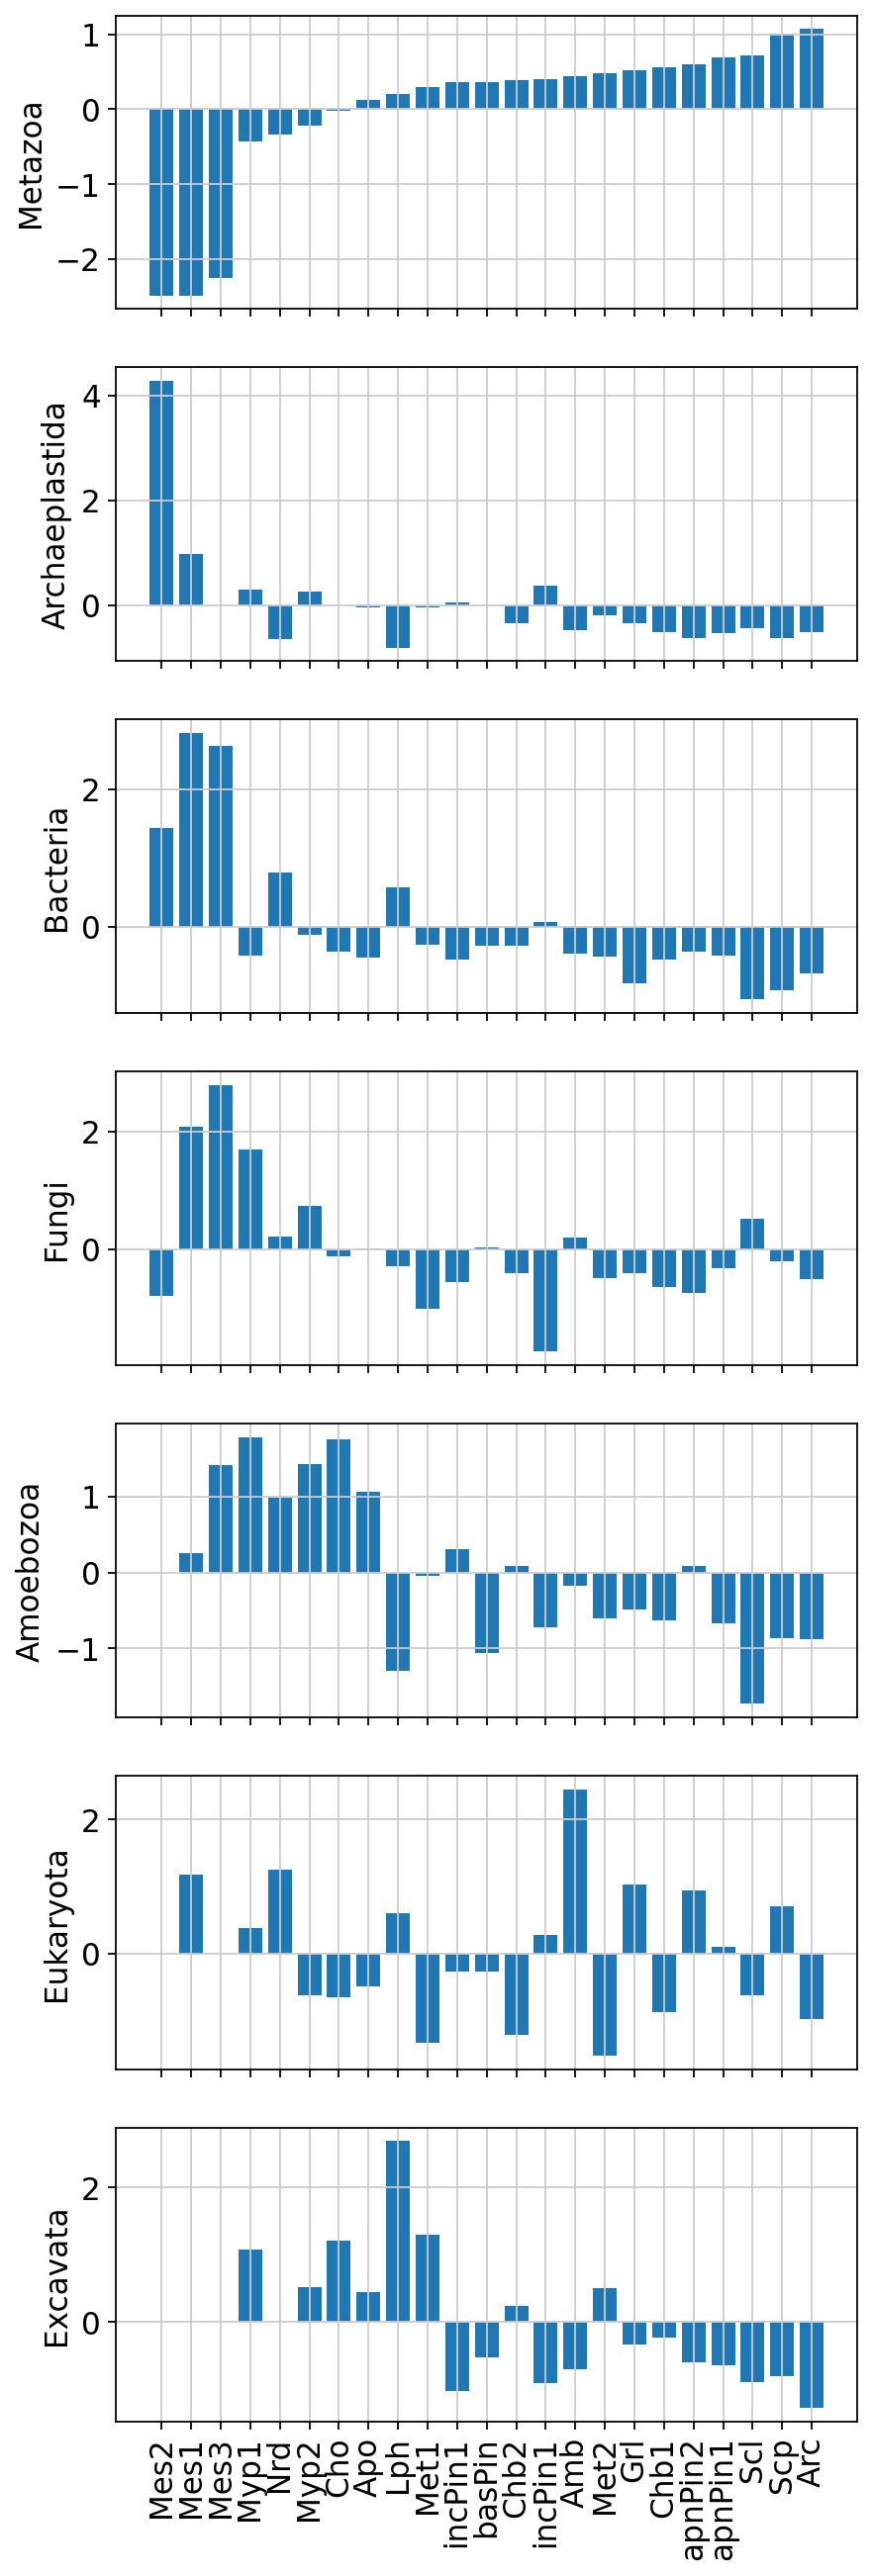

In [14]:
width = 0.35
fig, ax = plt.subplots(figsize=(6, 20), sharex=True, nrows=len(eggnog_categories[:7]))
for i, tax in enumerate(eggnog_categories[:7]):
    ax[i].bar(perc_metazoa, eggnog_summary.loc[tax])
    ax[i].set_ylabel(tax.split()[0])
    
short_names = eggnog_summary.columns.str.split().str[-1].str[1:-1]
ax[i].set_xticklabels(short_names, rotation=90);

The only instance where we go above 3σ is with Mesocytes 2 in the case of plant genes. Something to look into?